## Plot Different Sketch for Measuring Flow Size Distribution
    

---

## Define common functions

In [20]:
import pickle
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import random
import json
import os

In [21]:
def read_data(algo='cm', row=3, width=4096, level=1, seed=1, count=1, flowkey='srcIP', 
              epochs=['30'], dataset='equinix-nyc.dirA.20180517-130100.UTC.anon.pcap/'):
    res = {}
    res[algo] = []
    for epoch in epochs:
        
        path = f"../SketchFlowSizeQuery/{algo}/{dataset}"\
                f"{flowkey}/row_{row}_width_{width}_level_{level}_epoch_{epoch}_count_{count}_seed_{seed}/"
        
        for dir in sorted(os.listdir(path)):
            p = os.path.join(path, dir)
            if os.path.isdir(p): 
                full_path = os.path.join(path, dir, "error.txt")    
                with open(full_path, 'r') as f:
                    ll = f.read()
                res[algo].append(ll)
            
    return res

read_data()

{'cm': ['1.7179962894248608', '1.6545454545454545']}

In [22]:
## Define mapping dictionary for index <---> metric
algos = ['univmon', 'cm', 'cs', 'hll', 'lc', 'mrac', 'll', 'mrb']
def get_metric_mapping(algos = ['univmon', 'cm', 'cs', 'hll']):
    mapping = {}
    for k in algos:
        mapping[k] = {}

    if 'univmon' in algos:
        # UNIV: [true_entropy, sim_entropy, sim_entropy_error, true_card, sim_card, sim_card_error, ARE]
        mapping['univmon']['hh'] = 6
        mapping['univmon']['card'] = 5 
        mapping['univmon']['entropy'] = 2
    if 'cm' in algos:
        # cm: [entropy, entropy_est, relative_entropy_error, sim_ARE_error, sim_change_detection_error, WMRD]
        mapping['cm']['hh'] = 3
        mapping['cm']['entropy'] = 2
        mapping['cm']['change_det'] = 4
        mapping['cm']['fsd'] = 5
    if 'cs' in algos:
        # cs: [entropy, entropy_est, relative_entropy_error, sim_ARE_error, sim_change_detection_error, WMRD]
        mapping['cs']['hh'] = 3
        mapping['cs']['entropy'] = 2
        mapping['cs']['change_det'] = 4
        mapping['cs']['fsd'] = 5
    if 'hll' in algos:
        # hll: [true_cardinality, sim_cardinality, sim_error]
        mapping['hll']['card'] = 2
    if 'll' in algos:
        # ll: [true_cardinality, sim_cardinality, sim_error]
        mapping['ll']['card'] = 2
    if 'lc' in algos:
        # lc: [true_cardinality, sim_cardinality, sim_error]
        mapping['lc']['card'] = 2
    if 'mrac' in algos:
        # mrac: [WMRD, entropy_true, entropy_est, entropy_err]
        mapping['mrac']['fsd'] = 0
        mapping['mrac']['entropy'] = 3
    if 'mrb' in algos:
        # mrb: [true_cardinality, sim_cardinality, sim_error]
        mapping['mrb']['card'] = 2
    return mapping
mapping = get_metric_mapping(algos)

In [23]:
def get_single_result(algo='cm', row=3, width=4096, level=1, seeds=[1, 2, 3], 
                           count=1, flowkey="srcIP", epochs = ['30'],
                     datasets = ['equinix-nyc.dirA.20180517-130100.UTC.anon.pcap/', 'equinix-nyc.dirA.20180517-131000.UTC.anon.pcap/']):
    # key: seed, row, width
    total_ret = {}
    for seed in seeds:
        total_ret[seed] = {}
        total_ret[seed][row] = {}
        total_ret[seed][row][width] = []
        
    # get results from all seeds
    for seed in seeds:
        for dataset in datasets:
            tmp = read_data(algo, row, width, level, seed, count, flowkey, epochs, dataset)

            # epoch
            for val in tmp[algo]:
                total_ret[seed][row][width].append(float(val))
                
    # print(total_ret)
                    
    # get mean/median from all seed results
    # key: row, width
    final_ret = {}               
    final_ret[row] = {}
    final_ret[row][width] = []
    
    arr = None
    for seed in seeds:
        if arr is None:
            arr = total_ret[seed][row][width]
        else:
            arr = np.vstack([arr, total_ret[seed][row][width]])
    # get mean value from all seeds
    final_ret[row][width] = np.mean(arr, axis=0).tolist()
    
    return final_ret

# get_single_result()

In [24]:
def get_counter_size(algo = 'cm'):
    counter_size = 4
    if algo == 'hll' or algo == 'll':
        # int8
        counter_size = 1
    elif algo == 'lc' or algo == 'mrb':
        # 1 bit
        counter_size = 1/8
    return counter_size

# The original width is the number of counter, so it needs to multiply the size of the counter
def convert_width_to_real_byte(algo = 'cm', width=4096):
    counter_size = get_counter_size(algo)
    return width * counter_size

In [25]:
def get_mean_value(ret, row=3):
    data = 0.0
    for w in ret[row]:
        data = np.mean(ret[row][w])
    return data


In [75]:
def plot_impact_of_sketch_fsd(algos=['cm', 'cs', 'mrac'], rows = [3, 3, 1], 
                              widths = [[8192, 16384, 32768, 65536, 131072],
                                        [8192, 16384, 32768, 65536, 131072],
                                        [4096, 8192, 16384, 32768, 65536]],
                              level=[1, 1, 8], seeds=[1,2,3], count=1, flowkey='srcIP', epochs = ['30'],
                              datasets = ['equinix-nyc.dirA.20180517-130100.UTC.anon.pcap/', 'equinix-nyc.dirA.20180517-130500.UTC.anon.pcap/'],
                              dataset_num=1,
                              mem_constraint=[32768, 65536, 131072, 262144, 524288]):

    # get the mean result of the given metric 
    size = len(algos)
    data = {}
    dataset_name = []
    
    for dataset in datasets:
        dataset_name.append(dataset[0][21:25])
            
    for d in range(dataset_num):
        data[dataset_name[d]] = {}
        for i in range(size):
            data[dataset_name[d]][algos[i]] = []
            
    for d in range(dataset_num):
        for i in range(size):
            for w in widths[i]:
                ret = get_single_result(algos[i], rows[i], w, level[i], seeds, count, flowkey, epochs, datasets[d])
                mean_ret = get_mean_value(ret, rows[i])
                data[dataset_name[d]][algos[i]].append(mean_ret)
                
    print(data)
        
    # plot the figure
    x_labels = []
    for w in mem_constraint:
        w = convert_width_to_real_byte(algos[0], w)
        x_labels.append(str(int(w / 1024)))
        
    fig = plt.figure(figsize = (7, 5))

    # Creating axes instance
    ax = fig.add_axes([0, 0, 1, 1])

    # Creating plot
    alphas = [1, 0.8, 0.6]
    for d in range(dataset_num):
        for algo, val in data[dataset_name[d]].items():
            l = dataset_name[d] + "-" + str(algo)
            bp = ax.plot(mem_constraint, val, label=l)

    # plt.axvline(x = 8192, color = 'darkgreen', linestyle='--')

    ax.set_xticks(mem_constraint)
    
    ax.set_xticklabels(x_labels, fontsize=12)
    plt.xlabel("Width (KB)", fontsize=16)
        
    plt.yticks(fontsize=14)
        
    title_str = 'Flow Size Distribution'
    ylabel_str = "Weighted Mean Relative Difference (WMRD)"
    ylabel_fontsize = 14

    # if level > 1:
    #     title_str += f', Level: {level}'
    plt.title(title_str, fontsize=18)
    plt.ylabel(ylabel_str, fontsize=ylabel_fontsize)

    plt.legend(fontsize=12,ncol=3)
    
    # if isSaveFig:
    #     plt.savefig(f'figures/profiler/{algo.upper()}_{m}_profiling.png', format='png', bbox_inches='tight')
    
    # show plot
    plt.show()
        
# plot_impact_of_sketch_fsd()

---

### Plot Flow Size Distribution



---

#### Single Traffic

{'0517': {'cm': [1.6240925328075693, 1.602900257795501, 1.5843004313390354, 1.3265186878990978, 0.6820937488985462], 'cs': [1.617408826403992, 1.5873240944695401, 1.5359647248068797, 1.3540855720641147, 0.929496046392132], 'mrac': [0.7400821718278566, 0.4466361993134714, 0.4149268194230612, 0.39448210535860556, 0.37731918781086404]}}


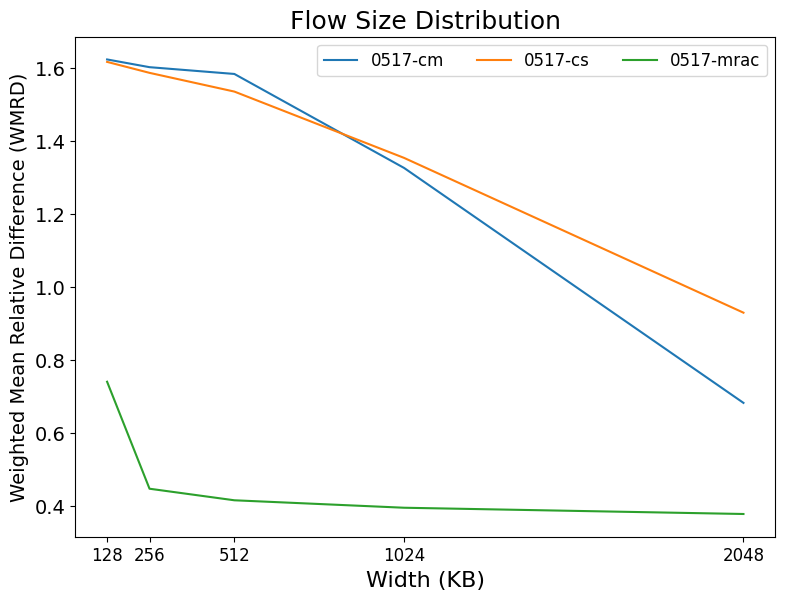

In [76]:
seeds = [1, 2, 3]
mem_constraint=[32768, 65536, 131072, 262144, 524288]

datasets = [['equinix-nyc.dirA.20180517-130100.UTC.anon.pcap/', 
             'equinix-nyc.dirA.20180517-130500.UTC.anon.pcap/',
             'equinix-nyc.dirA.20180517-131000.UTC.anon.pcap/',
             'equinix-nyc.dirA.20180517-133000.UTC.anon.pcap/',
             'equinix-nyc.dirA.20180517-140000.UTC.anon.pcap/']]

dataset_num = 1

algos = ['cm', 'cs', 'mrac']
rows = [3, 3, 1]
level=[1, 1, 8]
widths = widths = [[8192, 16384, 32768, 65536, 131072],
                   [8192, 16384, 32768, 65536, 131072],
                   [4096, 8192, 16384, 32768, 65536]]
count=1
flowkey='srcIP'
epochs = ['30']

plot_impact_of_sketch_fsd(algos, rows, widths, level, seeds, count, flowkey, epochs, datasets, dataset_num, mem_constraint)



---

#### Multiple Traffic

{'0517': {'cm': [1.6240925328075693, 1.602900257795501, 1.5843004313390354, 1.3265186878990978, 0.6820937488985462], 'cs': [1.617408826403992, 1.5873240944695401, 1.5359647248068797, 1.3540855720641147, 0.929496046392132], 'mrac': [0.7400821718278566, 0.4466361993134714, 0.4149268194230612, 0.39448210535860556, 0.37731918781086404]}, '0621': {'cm': [1.6273509074882753, 1.5955934058544474, 1.5688027574394279, 1.329996391680404, 0.6616358945728942], 'cs': [1.62090717976536, 1.591556281480739, 1.5419232190022458, 1.3541285103489666, 0.9194140433898594], 'mrac': [0.7387805718702046, 0.4457268947562092, 0.4206534809931319, 0.3949704211735741, 0.37724500340003414]}, '0816': {'cm': [1.64425674321689, 1.603919023544193, 1.5818416425635742, 1.339178426131366, 0.6780084844482573], 'cs': [1.6378989083392639, 1.5942245252549745, 1.541605760852781, 1.359054882662249, 0.9268229637935889], 'mrac': [0.7476631601697598, 0.44835158023120025, 0.42430399944016617, 0.39892414536762894, 0.3819428872554226]}

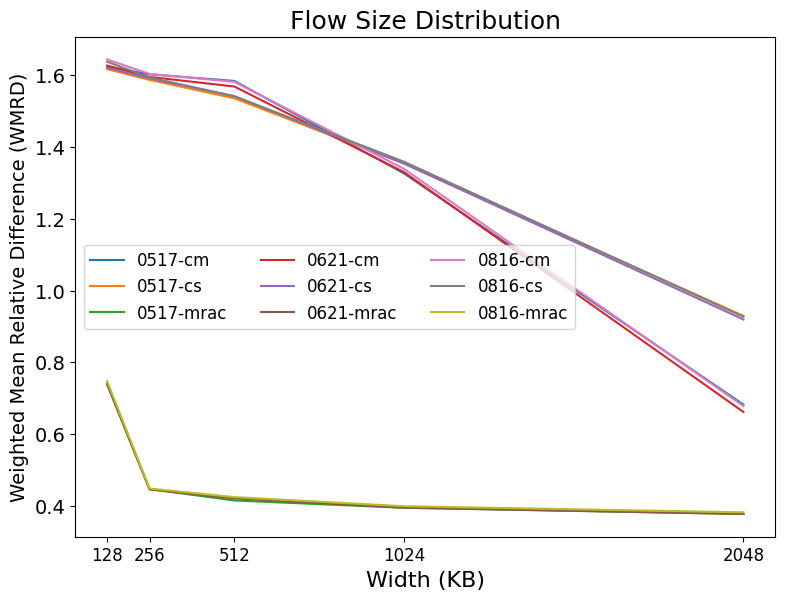

In [77]:
seeds = [1, 2, 3]
mem_constraint=[32768, 65536, 131072, 262144, 524288]

datasets = [['equinix-nyc.dirA.20180517-130100.UTC.anon.pcap/', 
             'equinix-nyc.dirA.20180517-130500.UTC.anon.pcap/',
             'equinix-nyc.dirA.20180517-131000.UTC.anon.pcap/',
             'equinix-nyc.dirA.20180517-133000.UTC.anon.pcap/',
             'equinix-nyc.dirA.20180517-140000.UTC.anon.pcap/'],
            ['equinix-nyc.dirA.20180621-130100.UTC.anon.pcap/', 
             'equinix-nyc.dirA.20180621-130500.UTC.anon.pcap/',
             'equinix-nyc.dirA.20180621-131000.UTC.anon.pcap/',
             'equinix-nyc.dirA.20180621-133000.UTC.anon.pcap/',
             'equinix-nyc.dirA.20180621-140000.UTC.anon.pcap/'],
            ['equinix-nyc.dirA.20180816-130100.UTC.anon.pcap/', 
             'equinix-nyc.dirA.20180816-130500.UTC.anon.pcap/',
             'equinix-nyc.dirA.20180816-131000.UTC.anon.pcap/',
             'equinix-nyc.dirA.20180816-133000.UTC.anon.pcap/',
             'equinix-nyc.dirA.20180816-140000.UTC.anon.pcap/'],]

dataset_num = 3

algos = ['cm', 'cs', 'mrac']
rows = [3, 3, 1]
level=[1, 1, 8]
widths = [[8192, 16384, 32768, 65536, 131072],
          [8192, 16384, 32768, 65536, 131072],
          [4096, 8192, 16384, 32768, 65536]]
count=1
flowkey='srcIP'
epochs = ['30']

plot_impact_of_sketch_fsd(algos, rows, widths, level, seeds, count, flowkey, epochs, datasets, dataset_num, mem_constraint)



